# ANÁLISIS DE SENTIMIENTOS DE LOS VACUNADOS CONTRA COVID-19 BASADO EN MACHINE LEARNING.

## Importando las librerías

In [36]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import re
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
import seaborn as sns

In [37]:
#!pip install gensim

In [38]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to C:\anaconda3\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\anaconda3\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\anaconda3\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## PASO 1: Cargando la data

In [39]:
train='C:/anaconda3/envs/sig39/Corona_NLP_train.csv'
test='C:/anaconda3/envs/sig39/Corona_NLP_test.csv'

In [40]:
trainOriginal = pd.read_csv(train, encoding='latin-1')
testOriginal = pd.read_csv(test, encoding='latin-1')

In [41]:
train = trainOriginal.copy()
test = testOriginal.copy()

In [42]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [43]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [45]:
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [46]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

## PASO 2: Análisis de datos y Visualización

Text(0.5, 1.0, 'Twitted locations')

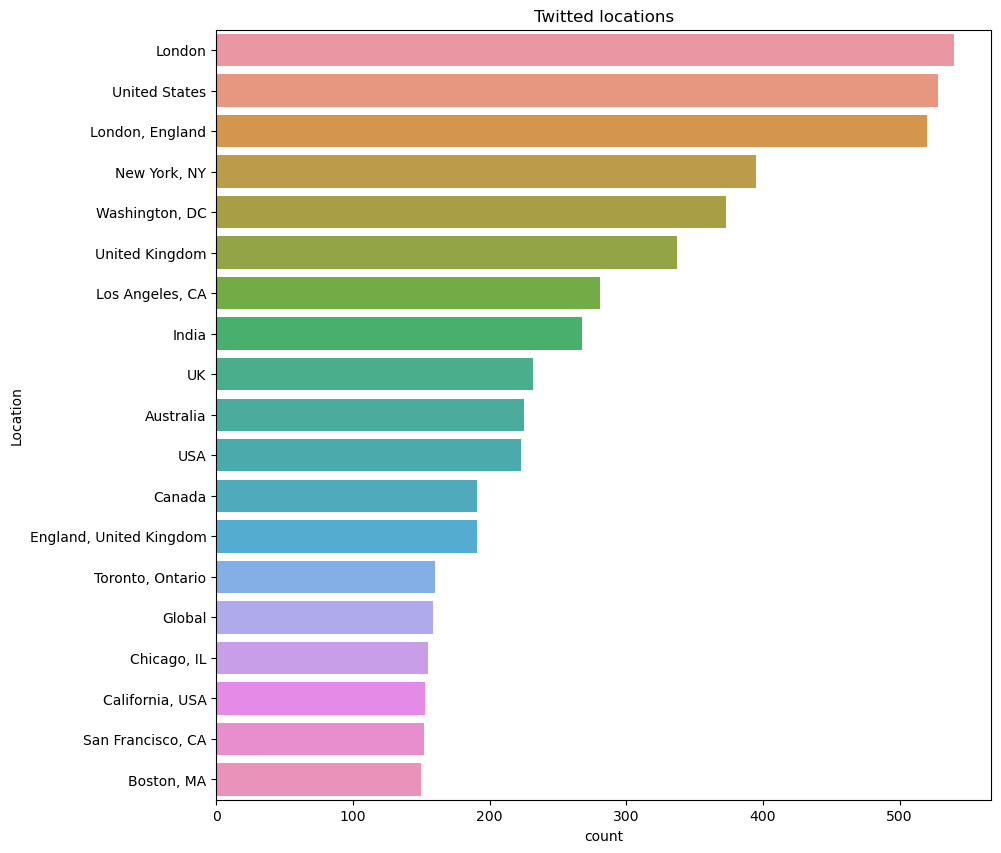

In [47]:
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data=train,order=train.Location.value_counts().iloc[
    0:19].index).set_title("Twitted locations")

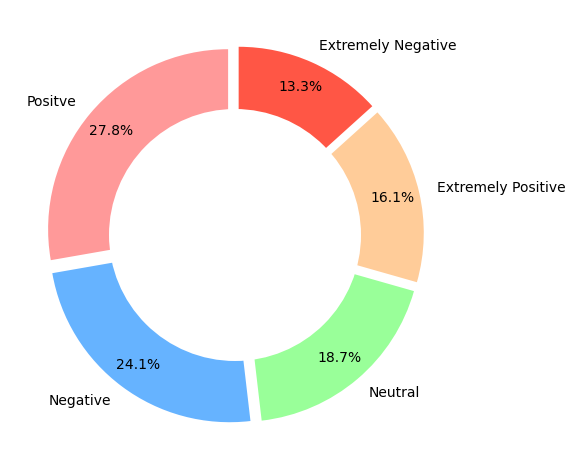

In [48]:
labels = ['Positve', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ff5645']
explode = (0.05,0.05,0.05,0.05,0.05) 
plt.pie(train.Sentiment.value_counts(), colors = colors, labels=labels,
        autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
centreCircle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)
plt.tight_layout()
plt.show()

#### Inferencias:
- La cantidad máxima de tweets pertenece a Sentimiento positivo seguido de negativo
- La relación positiva a negativa es bastante similar.

In [49]:
train['Identity'] = 0
test['Identity'] = 1 
covid = pd.concat([train, test])
covid.reset_index(drop=True, inplace=True)
covid.shape

(44955, 7)

In [50]:
# duplicated tweets
duplicates = covid[covid.duplicated()]
len(duplicates)

0

In [53]:
covid.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [54]:
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Positive', 'Positive')
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Negative', 'Negative')

In [55]:
covid = covid.drop('ScreenName', axis=1)
covid = covid.drop('UserName', axis=1)
covid

,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,0
...,...,...,...,...,...
44950,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,1
44951,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,1
44952,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,1
44953,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative,1


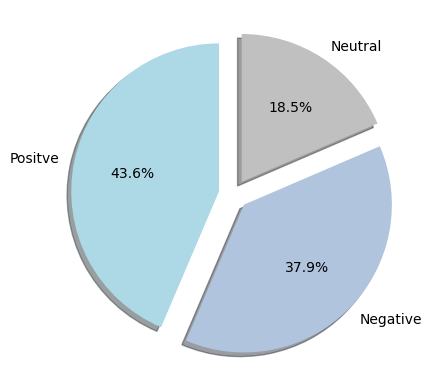

In [56]:
labels = ['Positve', 'Negative', 'Neutral']
colors = ['lightblue','lightsteelblue','silver']
explode = (0.1, 0.1, 0.1)
plt.pie(covid.Sentiment.value_counts(), colors = colors, labels=labels,
        shadow=300, autopct='%1.1f%%', startangle=90, explode = explode)
plt.show()

#### Inferencias
- Los tweets positivos siguen siendo máximos seguidos de negativos y neutrales respectivamente.

### PASO 2A: Preprocesamiento de datos

In [57]:
covid['Sentiment'] = covid['Sentiment'].map({'Neutral':0, 'Positive':1, 'Negative':2})

In [58]:
# count number of words per headline. strip whitespaces at the beginning/end of the sentence 
# and tokenize by whitespace
covid_select = covid[["OriginalTweet", "Sentiment"]]
covid_select["word_count"] = covid_select["OriginalTweet"].apply(lambda x: len(x.strip().split(" ")))
covid_select

C:\Users\RICARDO\AppData\Local\Temp\ipykernel_11936\1868428590.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,OriginalTweet,Sentiment,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,8
1,advice Talk to your neighbours family to excha...,1,38
2,Coronavirus Australia: Woolworths to give elde...,1,14
3,My food stock is not the only one which is emp...,1,40
4,"Me, ready to go at supermarket during the #COV...",2,38
...,...,...,...
44950,Meanwhile In A Supermarket in Israel -- People...,1,18
44951,Did you panic buy a lot of non-perishable item...,2,34
44952,Asst Prof of Economics @cconces was on @NBCPhi...,0,26
44953,Gov need to do somethings instead of biar je r...,2,29


In [59]:
for i in range (5):
    print(covid_select.OriginalTweet[i])
    print("========================================")

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j




#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n


In [60]:
# summary statistics of word counts
covid_select["word_count"].describe()

count    44955.000000
mean        30.471694
std         11.655990
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max        127.000000
Name: word_count, dtype: float64

In [61]:
fig = px.histogram(covid_select,
                  x='word_count',
                  marginal='box',
                  title="Length of original tweets")
fig.update_layout(bargap=0.1)
fig.show()

#### Inferencias
- Distribución algo normal sesgada hacia la derecha
- Los valores atípicos están presentes
- Rango de longitud se encuentra b/w 1 a 127

#### Necesidad de preprocesamiento
- Estos tweets contienen palabras y partes que no contribuyen al sentimiento que transmite.
- p.ej. : enlaces, símbolos, números, retornos de carro, espacios, URLS, etc.
- Por lo tanto, es necesario limpiar los datos para un mejor rendimiento.

In [28]:
#print(set(stopwords.words('english')))

{"needn't", 'during', 'yourselves', 'any', 'then', "shan't", 'a', 'this', 'by', 'their', 'at', 'while', 'in', 'should', 're', "you're", 'how', 'too', 'they', 'into', "aren't", "wasn't", 'again', 'all', 'such', 'after', 'with', 'hasn', 'be', 'having', 'other', 'shan', 'once', 'over', 'further', 'ain', 'couldn', "shouldn't", 'do', 'can', 'mustn', 'you', 'that', "it's", 'there', "hasn't", 'won', 'so', 'only', 'me', 'an', 'until', 'ma', 'which', "haven't", 've', 'have', 'because', 'are', "won't", 'if', 'wouldn', 'aren', 'here', 'theirs', 'yours', 'below', 'than', 'own', 'were', 'these', 'whom', 'about', 'down', 'i', 'but', 'your', 'does', 'himself', 'few', 'll', 'most', 'has', 'and', 'it', 'our', 'is', "she's", 'through', 'hers', 'weren', "you've", 'haven', 'between', 'what', 'we', 'he', 'his', "wouldn't", 'm', 'did', 'of', 'as', 'out', 'yourself', 'ourselves', 'same', 'don', 'mightn', 'd', 'no', "isn't", 'will', "that'll", 'been', 'some', 'myself', 'those', 'its', 'more', "mightn't", 't',

In [62]:
import string

def data_cleaning(data):
    cleaned_data = []
    fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
    fillerword_reg= "bye[.,]|so[.,]|yeah[.,]|okay[.,]|um[.,]|uh[.,]|mmm[.,]|ahan[.,]|uh[.,]|huh[.,]|ahm[.,]|oh[.,]|sooo[.,]|uh[.,]|huh[.,]|yeh[.,]|yah[.,]|hmm[.,]"
    STOPWORDS = set(stopwords.words('english'))
    remove=["doesn't","not","nor","neither","isn't","hadn't","mightn't","needn't","wasn't"]
    for i in remove:
        STOPWORDS.discard(i)
    
    STOPWORDS.add(fillerWord)  
    for i in range(len(data)):
        tweet = re.sub("#", "", data[i])#extracting hashtags
        tweet = re.sub(r'^https?:\/\/.*[\r\n]*', '',tweet, flags=re.MULTILINE)#extracting links
        html=re.compile(r'<.*?>')#extracting html tags
        tweet =html.sub(r"", tweet)
        #extracting symbols and characters
        tweet=re.sub(r'@\w+',"",tweet)
        tweet=re.sub(r'#\w+',"",tweet) 
        tweet=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) 
        punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        tweet.rstrip(string.punctuation)
        tweet=re.sub('[^A-Za-z\s]+',"", tweet)
        tweet = tweet.lower()
        tweet = tweet.split()
        #Lemmatization to normalise text
        tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in STOPWORDS]
        tweet = ' '.join(tweet)
        filler=re.compile(fillerword_reg)
        tweet=filler.sub("",tweet)
        cleaned_data.append(tweet)
    return cleaned_data

In [63]:
####Preprocessing and cleaning covid tweets data
texto_data=covid_select['OriginalTweet'].tolist()
process_text=data_cleaning(texto_data)

cleaned_tweet =pd.DataFrame(process_text)
covid_select['CleanedTweet']=cleaned_tweet
#cleaned_tweet.head()


covid_select

C:\Users\RICARDO\AppData\Local\Temp\ipykernel_11936\1839011947.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,OriginalTweet,Sentiment,word_count,CleanedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,8,
1,advice Talk to your neighbours family to excha...,1,38,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,1,14,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,1,40,food stock not one empty please dont panic eno...
4,"Me, ready to go at supermarket during the #COV...",2,38,ready go supermarket covid outbreak not im par...
...,...,...,...,...
44950,Meanwhile In A Supermarket in Israel -- People...,1,18,meanwhile supermarket israel people dance sing...
44951,Did you panic buy a lot of non-perishable item...,2,34,panic buy lot nonperishable item echo need foo...
44952,Asst Prof of Economics @cconces was on @NBCPhi...,0,26,asst prof economics talking recent research co...
44953,Gov need to do somethings instead of biar je r...,2,29,gov need somethings instead biar je rakyat ass...


In [64]:
#Adding length of cleaned tweet to dataset
covid_select['New-word_count']= covid_select['CleanedTweet'].apply(lambda x: len(x.strip().split(" ")))
covid_select

,OriginalTweet,Sentiment,word_count,CleanedTweet,New-word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,8,,1
1,advice Talk to your neighbours family to excha...,1,38,advice talk neighbour family exchange phone nu...,28
2,Coronavirus Australia: Woolworths to give elde...,1,14,coronavirus australia woolworth give elderly d...,12
3,My food stock is not the only one which is emp...,1,40,food stock not one empty please dont panic eno...,25
4,"Me, ready to go at supermarket during the #COV...",2,38,ready go supermarket covid outbreak not im par...,24
...,...,...,...,...,...
44950,Meanwhile In A Supermarket in Israel -- People...,1,18,meanwhile supermarket israel people dance sing...,10
44951,Did you panic buy a lot of non-perishable item...,2,34,panic buy lot nonperishable item echo need foo...,19
44952,Asst Prof of Economics @cconces was on @NBCPhi...,0,26,asst prof economics talking recent research co...,11
44953,Gov need to do somethings instead of biar je r...,2,29,gov need somethings instead biar je rakyat ass...,24


In [65]:
print(covid_select["New-word_count"].describe())
fig = px.histogram(covid_select,
                  x='New-word_count',
                  marginal='box',
                  title="Length of cleaned tweets",
                  color_discrete_sequence=['green'])
fig.update_layout(bargap=0.1)
fig.show()

count    44955.00000
mean        17.77740
std          6.65246
min          1.00000
25%         13.00000
50%         18.00000
75%         23.00000
max         40.00000
Name: New-word_count, dtype: float64


#### Inferencias:
- El rango cambió significativamente a 0-40
- Número de valores atípicos disminuidos

#### Separación de características y respuesta

In [66]:
X_train = covid_select.CleanedTweet
Y_train = covid_select.Sentiment

In [67]:
Y_train = covid_select.Sentiment
covid_select.shape

(44955, 5)

#### Label de Codificación de la respuesta, es decir, variables categóricas

In [68]:
from sklearn.preprocessing import LabelEncoder

In [69]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
#encoder.classes_

In [70]:
Y_train = pd.DataFrame(Y_train,columns=['Sentiment'])
Y_train.head()

,Sentiment
0,0
1,1
2,1
3,1
4,2


# PASO 3: Construir, evaluar y ajustar el modelo final

# Enfoque de aprendizaje profundo: un modelo RNN
- Las redes neuronales simples son simplemente del tipo feed-forward
- Una RNN es un tipo especial de red neuronal que procesará una palabra a la vez mientras mantiene una memoria interna de lo que ya ha visto.
- Esto le permitirá tratar las palabras de manera diferente en función de su orden en una oración y desarrollar lentamente una comprensión de la entrada completa, una palabra a la vez.
- En una capa RNN simple, la entrada de las marcas de tiempo anteriores desapareció gradualmente a medida que avanzábamos en la entrada. Con un LSTM tenemos una estructura de datos de memoria a largo plazo que almacena todas las entradas vistas anteriormente, así como cuándo las vimos. Esto nos permite acceder a cualquier valor anterior que queramos en cualquier momento. Esto se suma a la complejidad de nuestra red y le permite descubrir relaciones más útiles entre las entradas y cuándo aparecen.

In [35]:
print("X_train\n",X_train.head())
print("Y_train\n",Y_train.head())

X_train
 0                                                     
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
3    food stock not one empty please dont panic eno...
4    ready go supermarket covid outbreak not im par...
Name: CleanedTweet, dtype: object
Y_train
    Sentiment
0          0
1          1
2          1
3          1
4          2


### Tokenización, Secuenciación y Relleno

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [37]:
tokenizer = Tokenizer(num_words=50000, 
                      
                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>',
                      document_count=0)

In [38]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(Y_train)

wordindex=tokenizer.word_index

In [39]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()
#tokenizer_config['word_counts']

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [40]:
import tensorflow.keras.preprocessing.sequence as ps

In [41]:
max_length = 50
train_sequence = tokenizer.texts_to_sequences(X_train)
train_padding = ps.pad_sequences(train_sequence,maxlen=max_length,padding='post')

In [42]:
#train_padding[0]
train_padding.shape
Y_train.shape

(44955, 1)

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
y_train = OneHotEncoder().fit_transform(Y_train)

In [45]:
y_train.shape

(44955, 3)

## Construyendo el modelo

In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding,Dropout, Bidirectional

from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D

In [47]:
# Building the BASELINE MODEL
base_model = Sequential()
base_model.add(Embedding(50000,128,input_length=train_padding.shape[1]))
base_model.add(GlobalAveragePooling1D())
base_model.add(Dense(8,activation='relu'))
base_model.add(Dense(3,activation='softmax'))

In [48]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           6400000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 6,401,059
Trainable params: 6,401,059
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Compiling the model

base_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [50]:
y_train=np.array(y_train.toarray())

In [51]:
train_padding=np.array(train_padding)

In [52]:
#Fitting the model

history_base = base_model.fit(train_padding,y_train ,epochs=10, validation_split=0.2)

Epoch 1/10
1124/1124 [==============================] - 119s 105ms/step - loss: 0.7951 - accuracy: 0.6484 - val_loss: 0.6145 - val_accuracy: 0.7633
Epoch 2/10
1124/1124 [==============================] - 119s 106ms/step - loss: 0.4520 - accuracy: 0.8494 - val_loss: 0.5598 - val_accuracy: 0.7978
Epoch 3/10
1124/1124 [==============================] - 115s 103ms/step - loss: 0.3161 - accuracy: 0.9028 - val_loss: 0.5786 - val_accuracy: 0.8020
Epoch 4/10
1124/1124 [==============================] - 119s 106ms/step - loss: 0.2379 - accuracy: 0.9308 - val_loss: 0.6432 - val_accuracy: 0.7895
Epoch 5/10
1124/1124 [==============================] - 119s 106ms/step - loss: 0.1872 - accuracy: 0.9459 - val_loss: 0.7003 - val_accuracy: 0.7780
Epoch 6/10
1124/1124 [==============================] - 113s 100ms/step - loss: 0.1498 - accuracy: 0.9573 - val_loss: 0.7879 - val_accuracy: 0.7702
Epoch 7/10
1124/1124 [==============================] - 116s 103ms/step - loss: 0.1229 - accuracy: 0.9639 - val_

#### Visualización de rendimiento

C:\Users\RICARDO\AppData\Local\Temp\ipykernel_14900\3733130098.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



(0.0, 1.2152100902050733)

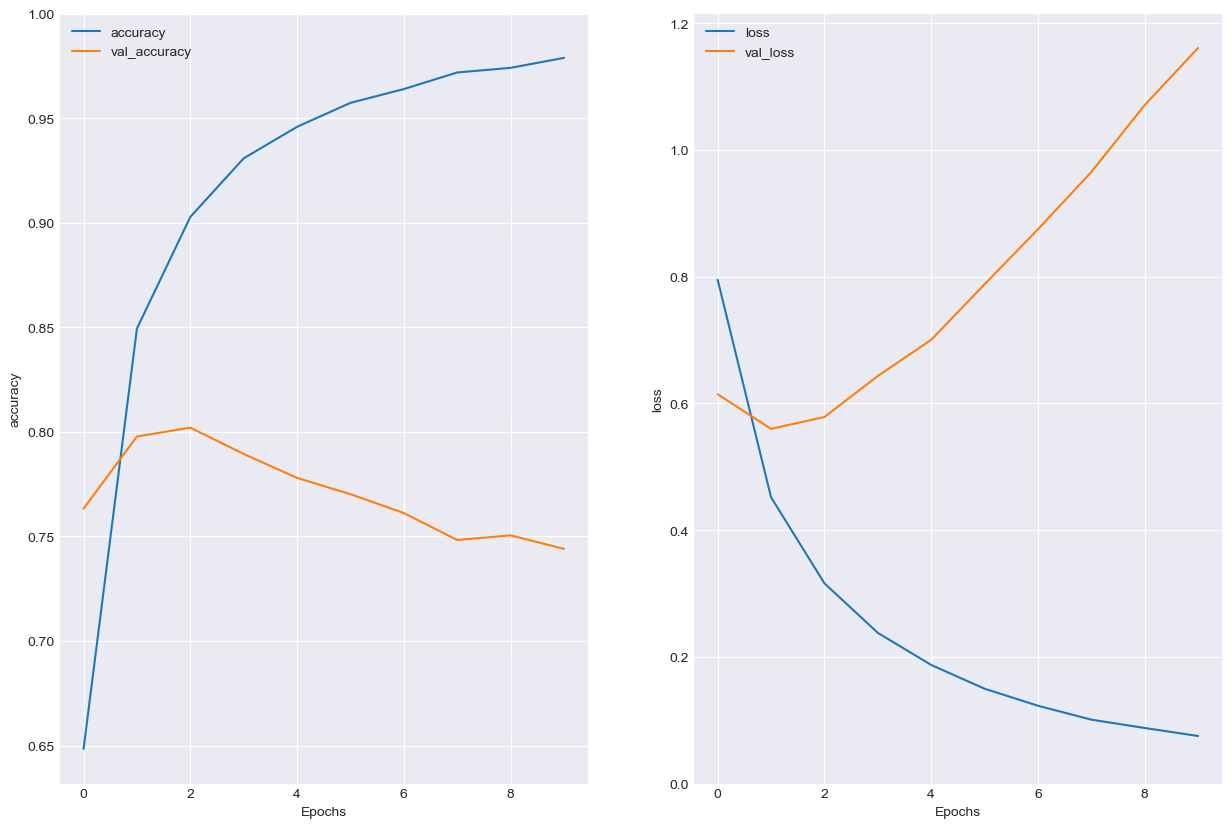

In [53]:
plt.style.use('seaborn-darkgrid')
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_base, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_base, 'loss')
plt.ylim(0, None)

### Inferencias:
- El modelo funciona bien con los datos de entrenamiento, pero tiene una diferencia significativa entre los datos de entrenamiento y los datos de validación.
- El modelo es de naturaleza sobreajustada.

## Manejo del sobreajuste

In [54]:
regularise = tensorflow.keras.regularizers.l2(0.001)

model_r = Sequential()
model_r.add(Embedding(50000,128,input_length=train_padding.shape[1]))
model_r.add(Dropout(0.5))
model_r.add(GlobalAveragePooling1D())
model_r.add(Dense(8,activation='relu',kernel_regularizer=regularise))
model_r.add(Dropout(0.5))
model_r.add(Dense(3,activation='softmax'))
model_r.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           6400000   
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                      

In [55]:
#Compiling the model
model_r.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [56]:
#Fitting the model

history_r = model_r.fit(train_padding,y_train ,epochs=8, validation_split=0.2)

Epoch 1/8
1124/1124 [==============================] - 112s 99ms/step - loss: 0.9809 - accuracy: 0.5315 - val_loss: 0.8410 - val_accuracy: 0.6484
Epoch 2/8
1124/1124 [==============================] - 111s 99ms/step - loss: 0.7989 - accuracy: 0.6704 - val_loss: 0.7184 - val_accuracy: 0.6963
Epoch 3/8
1124/1124 [==============================] - 112s 99ms/step - loss: 0.6970 - accuracy: 0.7142 - val_loss: 0.6699 - val_accuracy: 0.7275
Epoch 4/8
1124/1124 [==============================] - 112s 100ms/step - loss: 0.6369 - accuracy: 0.7503 - val_loss: 0.6464 - val_accuracy: 0.7734
Epoch 5/8
1124/1124 [==============================] - 112s 100ms/step - loss: 0.5944 - accuracy: 0.7656 - val_loss: 0.6364 - val_accuracy: 0.7767
Epoch 6/8
1124/1124 [==============================] - 111s 99ms/step - loss: 0.5656 - accuracy: 0.7788 - val_loss: 0.6307 - val_accuracy: 0.7857
Epoch 7/8
1124/1124 [==============================] - 112s 100ms/step - loss: 0.5376 - accuracy: 0.7927 - val_loss: 0.630

(0.0, 1.0043579757213592)

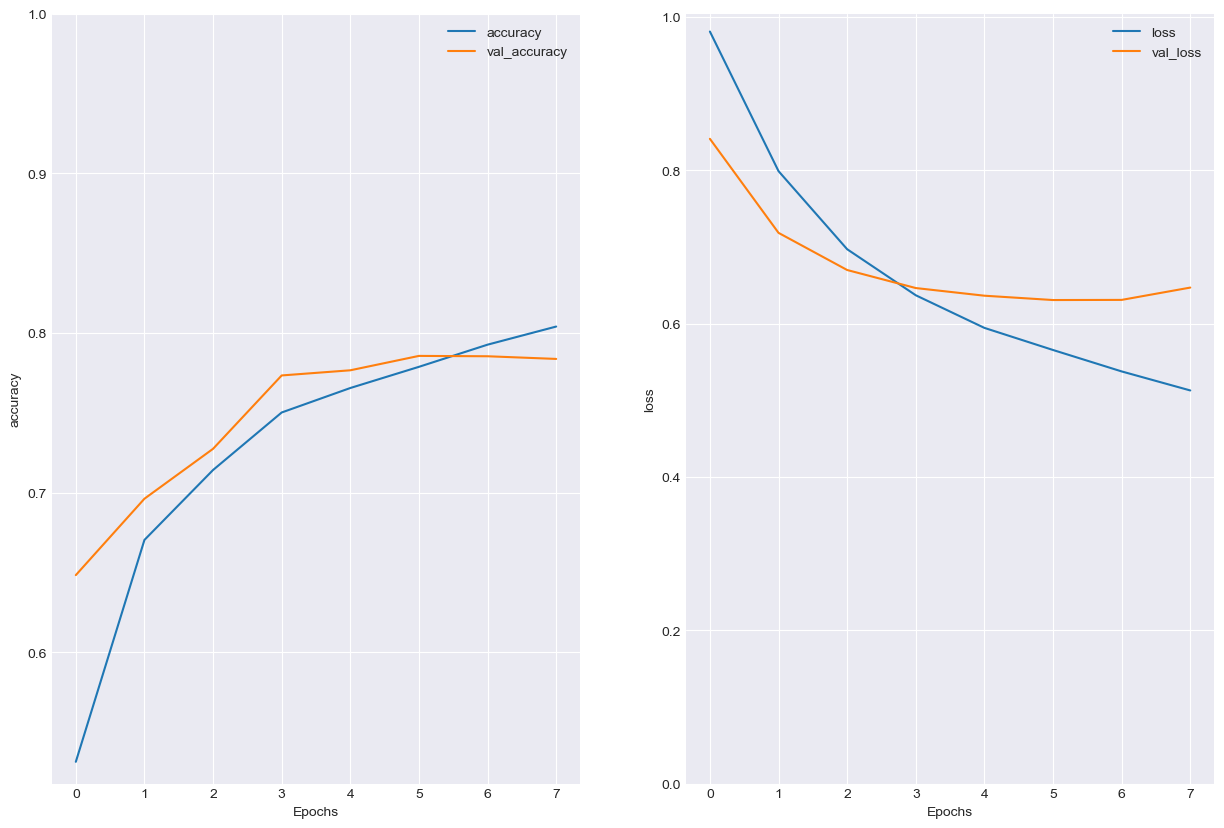

In [57]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_r, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_r, 'loss')
plt.ylim(0, None)

#### Evaluación del modelo

In [59]:
score = model_r.evaluate(train_padding,y_train) 
print("Testing Accuracy(%): ", score[1]*100)

1405/1405 [==============================] - 2s 1ms/step - loss: 0.3971 - accuracy: 0.9031
Testing Accuracy(%):  90.30808806419373


In [60]:
y_pred = model_r.predict(train_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_train])

1405/1405 [==============================] - 2s 1ms/step


In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
cm = confusion_matrix(y_test_labels, y_predicted_labels)

In [63]:
import seaborn as sn

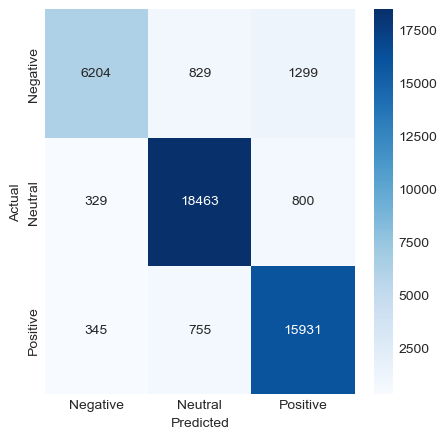

In [64]:
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Inferencias:
- Este modelo redujo el sobreajuste hasta cierto punto
- Da un buen rendimiento con una precisión de alrededor del 78%

## Uso de LSTM: (Long Short-Term Memory - Memoria a largo plazo)
- En la capa RNN simple, la entrada de las marcas de tiempo anteriores desapareció gradualmente a medida que avanzábamos en la entrada.
- Con un LSTM tenemos una estructura de datos de memoria a largo plazo que almacena todas las entradas vistas anteriormente, así como cuando las vimos.
- Esto nos permite acceder a cualquier valor anterior que queramos en cualquier momento.
- Esto se suma a la complejidad de nuestra red y le permite descubrir relaciones más útiles entre las entradas y cuándo aparecen.

In [65]:
from keras.constraints import max_norm

In [66]:
#Building the model
model1 = Sequential([
    Embedding(50000,128,input_length=train_padding.shape[1]),
    Dropout(0.5),
    LSTM(32,kernel_constraint=max_norm(3)),
    Dense(32,activation='relu',kernel_regularizer=regularise),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
#Compiling the model
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#Fitting the model
history1 =  model1.fit(train_padding,y_train ,epochs=8, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/8
1124/1124 [==============================] - 132s 115ms/step - loss: 0.9259 - accuracy: 0.5528 - val_loss: 0.7488 - val_accuracy: 0.7031
Epoch 2/8
1124/1124 [==============================] - 146s 130ms/step - loss: 0.6548 - accuracy: 0.7638 - val_loss: 0.6407 - val_accuracy: 0.7460
Epoch 3/8
1124/1124 [==============================] - 157s 139ms/step - loss: 0.4890 - accuracy: 0.8386 - val_loss: 0.5733 - val_accuracy: 0.8018
Epoch 4/8
1124/1124 [==============================] - 158s 140ms/step - loss: 0.3875 - accuracy: 0.8808 - val_loss: 0.5976 - val_accuracy: 0.8154
Epoch 5/8
1124/1124 [==============================] - 145s 129ms/step - loss: 0.3572 - accuracy: 0.8877 - val_loss: 0.6258 - val_accuracy: 0.8123
Epoch 6/8
1124/1124 [==============================] - 144s 128ms/step - loss: 0.2882 - accuracy: 0.9120 - val_loss: 0.6597 - val_accuracy: 0.8020


(0.0, 0.9577829331159592)

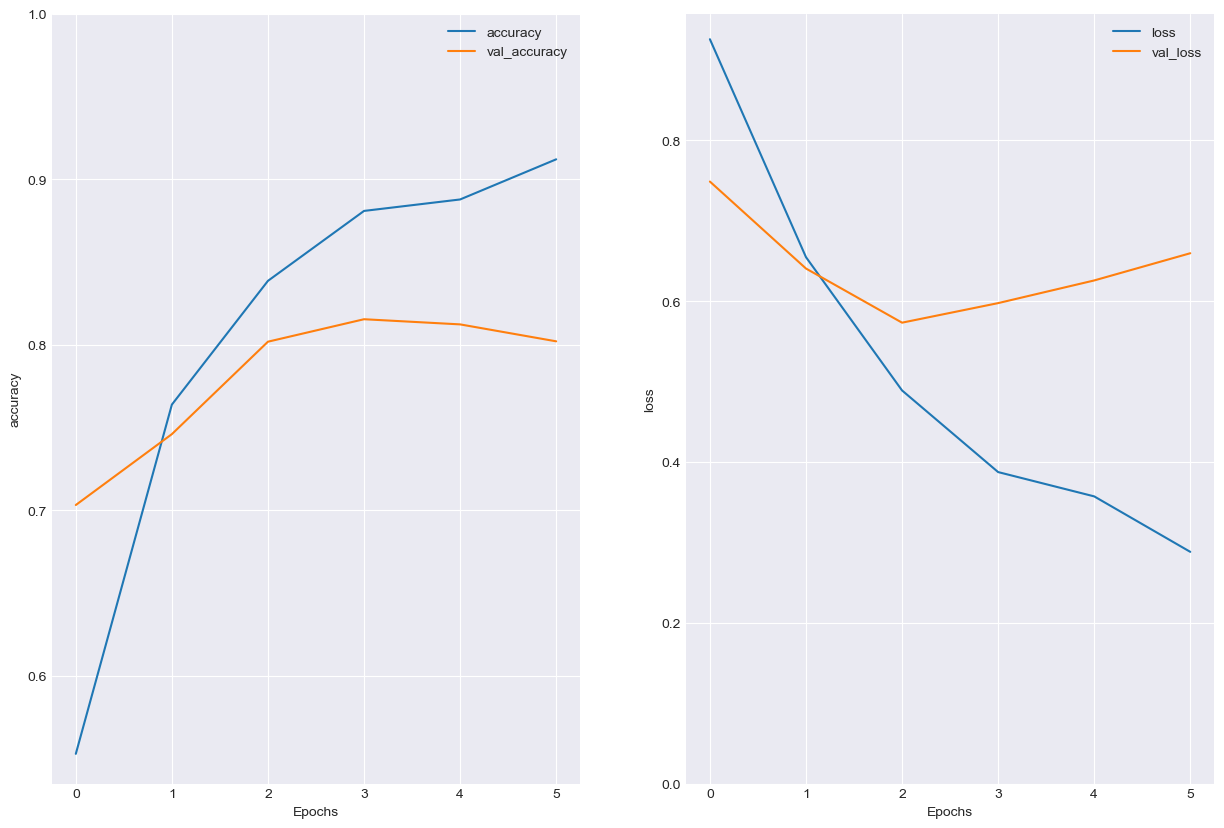

In [67]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')
plt.ylim(0, None)

#### Evaluación del modelo

In [70]:
score = model1.evaluate(train_padding,y_train) 
print("Testing Accuracy(%): ", score[1]*100)

1405/1405 [==============================] - 10s 7ms/step - loss: 0.2864 - accuracy: 0.9082
Testing Accuracy(%):  90.81525802612305


In [71]:
y_pred = model1.predict(train_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_train])

1405/1405 [==============================] - 11s 7ms/step


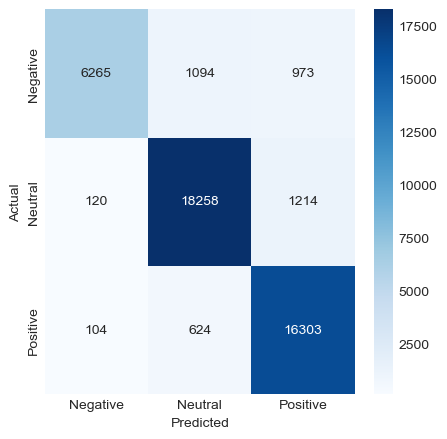

In [72]:
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
print('\n=================Classification Report========================\n')
print(classification_report(y_test_labels, y_predicted_labels, target_names=['Class  Negative',	 'Class Neutral','Class positive']))


=================Classification Report========================

                 precision    recall  f1-score   support

Class  Negative       0.97      0.75      0.85      8332
  Class Neutral       0.91      0.93      0.92     19592
 Class positive       0.88      0.96      0.92     17031

       accuracy                           0.91     44955
      macro avg       0.92      0.88      0.90     44955
   weighted avg       0.91      0.91      0.91     44955



#### Inferencias:
El modelo con LSTM se desempeñó mucho mejor que el RNN simple, ya que hay un aumento en la precisión, tanto en el entrenamiento como en las pruebas.
Se realizó un poco de ajuste de hiperparámetros para evitar el sobreajuste

## Uso de BI-LSTM: ((Bi-directional long short term memory - Memoria bidireccional a largo plazo)

In [74]:
#Building the model
model2 = Sequential([
    Embedding(50000,128,input_length=train_padding.shape[1]),
    Bidirectional(LSTM(128,return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])
#Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#Fitting the model
history2 =  model2.fit(train_padding,y_train ,epochs=8, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/8
1124/1124 [==============================] - 248s 208ms/step - loss: 0.6588 - accuracy: 0.7427 - val_loss: 0.4700 - val_accuracy: 0.8301
Epoch 2/8
1124/1124 [==============================] - 252s 224ms/step - loss: 0.3619 - accuracy: 0.8846 - val_loss: 0.4958 - val_accuracy: 0.8263
Epoch 3/8
1124/1124 [==============================] - 228s 203ms/step - loss: 0.2275 - accuracy: 0.9290 - val_loss: 0.5714 - val_accuracy: 0.8353
Epoch 4/8
1124/1124 [==============================] - 192s 171ms/step - loss: 0.1552 - accuracy: 0.9508 - val_loss: 0.6446 - val_accuracy: 0.8254


(0.0, 0.6840167284011841)

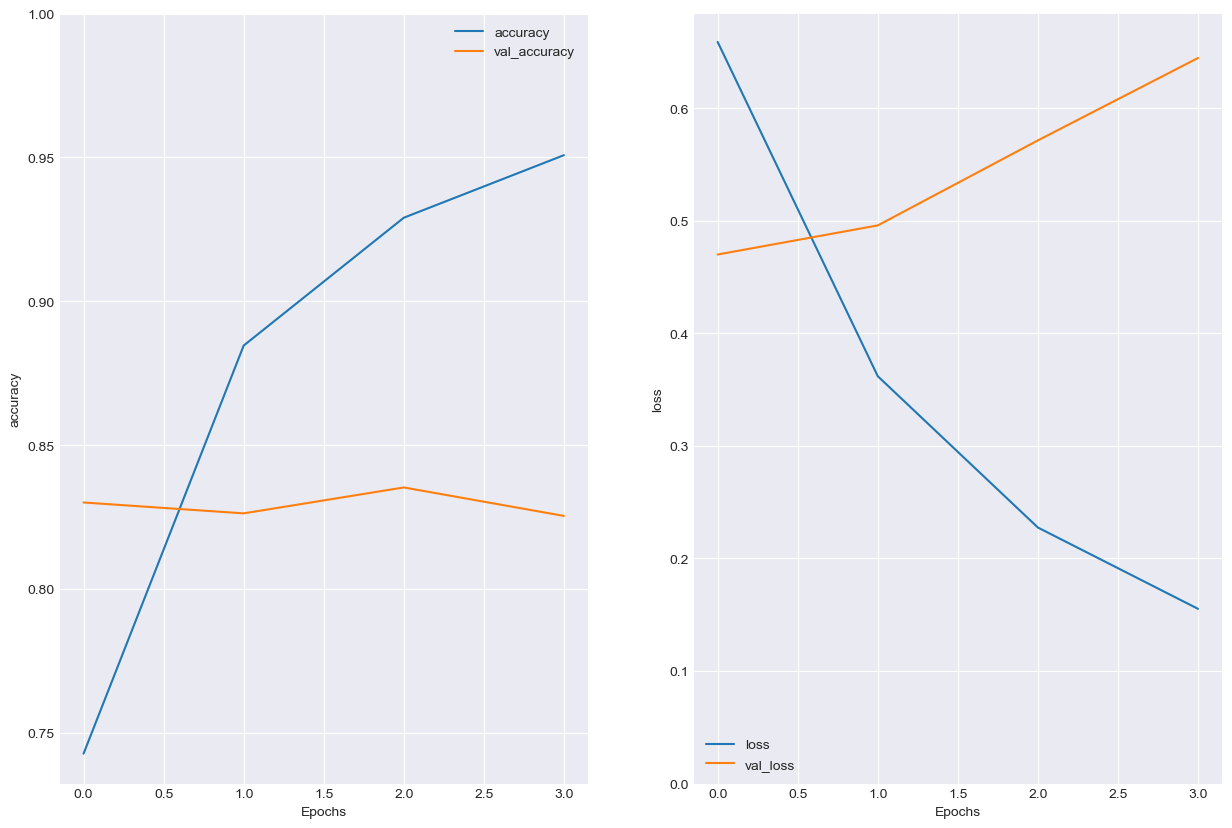

In [75]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')
plt.ylim(0, None)

#### Evaluación del modelo

In [76]:
score = model2.evaluate(train_padding,y_train) 
print("Testing Accuracy(%): ", score[1]*100)

1405/1405 [==============================] - 45s 32ms/step - loss: 0.1967 - accuracy: 0.9398
Testing Accuracy(%):  93.98064613342285


In [77]:
y_pred = model2.predict(train_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_train])

1405/1405 [==============================] - 53s 36ms/step


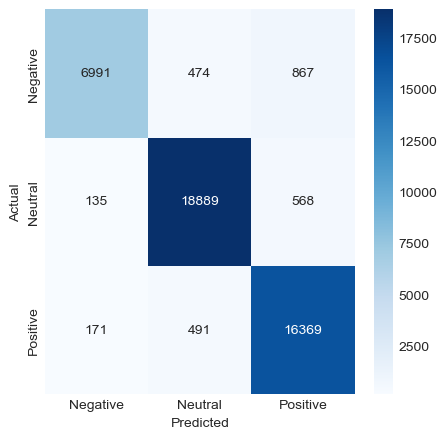

In [78]:
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [79]:
from sklearn.metrics import classification_report
print('\n=================Classification Report for Bidirectional LSTM========================\n')
print(classification_report(y_test_labels, y_predicted_labels, target_names=['Class  Negative',	 'Class Neutral','Class positive']))


=================Classification Report for Bidirectional LSTM========================

                 precision    recall  f1-score   support

Class  Negative       0.96      0.84      0.89      8332
  Class Neutral       0.95      0.96      0.96     19592
 Class positive       0.92      0.96      0.94     17031

       accuracy                           0.94     44955
      macro avg       0.94      0.92      0.93     44955
   weighted avg       0.94      0.94      0.94     44955



##### Inferencias:
- Aunque el modelo tiene una mejor métrica de precisión que LSTM, sufre de sobreajuste

# **Conclusion**

- Al tratar con la declaración del problema relacionado con el análisis de sentimientos, la secuencia de datos juega un papel importante
- Por lo tanto, los modelos tradicionales de ML dan malos resultados
- Para ayudar al modelo a conservar la secuencia y comprender el significado de la característica de datos en forma de texto, la red neuronal recurrente, es decir, RNN, se utiliza como modelo de referencia.
- LSTM y LSTM bidireccional se construyeron para mejorar aún más la precisión
- Aunque este último dio una mejor precisión, sufrió el problema del sobreajuste.
- Por lo tanto, para este conjunto de datos, LSTM parece ser el modelo factible. Durante alrededor de 5 épocas, dio una precisión de alrededor del 82%